# Preparation

In [1]:
import csv
import regex
import datetime as dt
from datetime import timedelta
import locale
locale.setlocale(locale.LC_TIME, 'id-ID.UTF-8')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.spatial.distance import cdist
from kneed import KneeLocator
from sklearn import preprocessing
from sklearn.metrics import silhouette_score

from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

from mlxtend.frequent_patterns import fpgrowth
from mlxtend.frequent_patterns import association_rules

import warnings
warnings.filterwarnings("ignore")
#from feature_engine.outlier_removers import Winsorizer

In [27]:
def check_skew(df_skew, column):
    skew = stats.skew(df_skew[column])
    skewtest = stats.skewtest(df_skew[column])
    plt.title('Distribution of ' + column)
    sns.distplot(df_skew[column], kde=False)
    
    print("{}'s: Skew: {}, : {}".format(column, skew, skewtest))
    return

def norm_minmax(df):
    result = df.copy()
    for feature_name in df.columns:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result

def kmeans(normalised_df_lrfm, clusters_number, original_df_lrfm):
    
    kmeans = KMeans(n_clusters = clusters_number, random_state = 1)
    kmeans.fit(normalised_df_lrfm)

    # Extract cluster labels
    cluster_labels = kmeans.labels_
        
    # Create a cluster label column in original dataset
    df_new = original_df_lrfm.assign(Cluster = cluster_labels)
    
    # Initialise TSNE
    model = TSNE(random_state=1)
    transformed = model.fit_transform(df_new)
    
    # Plot t-SNE
    plt.title('Flattened Graph of {} Clusters'.format(clusters_number))
    sns.scatterplot(x=transformed[:,0], y=transformed[:,1], hue=cluster_labels, style=cluster_labels, palette="Set1")
    
    return df_new

def snake_plot(normalised_df_lrfm, df_lrfm_kmeans, df_lrfm_original):

    normalised_df_lrfm = pd.DataFrame(normalised_df_lrfm, 
                                       index=df_lrfm_original.index, 
                                       columns=df_lrfm_original.columns)
    normalised_df_lrfm['Cluster'] = df_lrfm_kmeans['Cluster']

    # Melt data into long format
    df_melt = pd.melt(normalised_df_lrfm.reset_index(), 
                        id_vars=['telp', 'Cluster'],
                        value_vars=['Length', 'Recency', 'Frequency', 'Monetary'], 
                        var_name='Metric', 
                        value_name='Value')

    plt.xlabel('Metric')
    plt.ylabel('Value')
    sns.pointplot(data=df_melt, x='Metric', y='Value', hue='Cluster')
    
    return

def threeD_plot(df_lrfm_kmeans, df_lrfm_original):
    from mpl_toolkits.mplot3d import Axes3D
    
    df_merge = pd.merge(df_lrfm_kmeans, df_lrfm_original['Cluster'], on='telp', how='left')

    x = np.array(df_merge['Recency'])
    y = np.array(df_merge['Frequency'])
    z = np.array(df_merge['Monetary'])

    plt.xlabel('Recency')
    plt.ylabel('Frequency')
    # plt.zlabel('Monetary')  
    ax.legend('Cluster')
    ax.scatter(x,y,z, s=(df_merge['Length']*40), marker="s", c=df_merge["Cluster"], cmap="Paired")


    return

## Import dataset

In [3]:
df = pd.read_csv("Coret-Coret Marketing_Transaction Details (TA Hammam)_2003-2105.csv")
# df = pd.read_csv("Coret-Coret Marketing_Transaction Details (TA Hammam)_1904-2104.csv")
display(df.info())
df.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57098 entries, 0 to 57097
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   delivery_date     57098 non-null  object 
 1   delivery_status   57098 non-null  object 
 2   no_order          57098 non-null  object 
 3   Channel           57098 non-null  object 
 4   transaction_type  57098 non-null  object 
 5   ID CL             33394 non-null  float64
 6   nama_komunitas    29526 non-null  object 
 7   name              57098 non-null  object 
 8   username          57080 non-null  object 
 9   useremail         57080 non-null  object 
 10  telp              57021 non-null  object 
 11  prod_id           56358 non-null  float64
 12  produk            56358 non-null  object 
 13  harga             57098 non-null  float64
 14  qty               57098 non-null  float64
 15  subtotal          57098 non-null  float64
dtypes: float64(5), object(11)
memory usage: 

None

delivery_date delivery_status no_order   Channel transaction_type  ID CL  \
0    2 Mar 2020       delivered  Z39CJIP  End User           normal    NaN   
1    2 Mar 2020       delivered  Z39CJIP  End User           normal    NaN   
2    2 Mar 2020       delivered  Z39CJIP  End User           normal    NaN   
3    2 Mar 2020       delivered  Z39CJIP  End User           normal    NaN   
4    2 Mar 2020       delivered  Z39EJQS  End User           normal    NaN   
5    2 Mar 2020       delivered  Z39EJQS  End User           normal    NaN   
6    2 Mar 2020       delivered  Z39H8ES  End User           normal    NaN   
7    2 Mar 2020       delivered  Z39HQYJ  End User           normal    NaN   
8    2 Mar 2020       delivered  Z39HUHM  End User           normal    NaN   
9    2 Mar 2020       delivered  Z39JDVP  End User           normal    NaN   

  nama_komunitas                          name               username  \
0            NaN                Event PKK RW 7  Ternakfresh Indonesia   
1            NaN                Event PKK RW 7  Ternakfresh Indonesia   
2            NaN                Event PKK RW 7  Ternakfresh Indonesia   
3            NaN                Event PKK RW 7  Ternakfresh Indonesia   
4            NaN                        Fahrul  Ternakfresh Indonesia   
5            NaN                        Fahrul  Ternakfresh Indonesia   
6            NaN                      Bu Wahyu  Ternakfresh Indonesia   
7            NaN                     Mpok Sari  Ternakfresh Indonesia   
8            NaN  Bu Sri Pasar Menur Pumpungan  Ternakfresh Indonesia   
9            NaN                  Mida Asyafii           Mida Asyafii   

                useremail          telp  prod_id  \
0    ternakmart@gmail.com  081381306699    177.0   
1    ternakmart@gmail.com  081381306699    179.0   
2    ternakmart@gmail.com  081381306699    159.0   
3    ternakmart@gmail.com  081381306699    147.0   
4    ternakmart@gmail.com  081381306699     47.0   
5    ternakmart@gmail.com  081381306699     60.0   
6    ternakmart@gmail.com  081331122428    169.0   
7    ternakmart@gmail.com  081381306699    154.0   
8    ternakmart@gmail.com  081381306699    154.0   
9  mida.asyafii@gmail.com  628121619805     47.0   

                                           produk     harga  qty  subtotal  
0             DAGING AYAM KARKAS 800GR PARTING 10   28000.0  4.0  112000.0  
1                        DAGING AYAM KARKAS 900GR   30000.0  1.0   30000.0  
2                      DAGING AYAM FILLET DADA KG   87500.0  1.0   87500.0  
3  TELUR AYAM NEGERI PREMIUM 1PACK (ISI 10 BUTIR)   17500.0  4.0   70000.0  
4                     JABMILK SUSU RASA COKLAT 1L   20000.0  1.0   20000.0  
5        JAB YOGURT STROBERI 250ML [DISCONTINUED]    8000.0  1.0    8000.0  
6               DAGING AYAM KARKAS 1KG PARTING 12   33000.0  2.0   66000.0  
7                          TELUR AYAM NEGERI 10KG  230000.0  1.0  230000.0  
8                          TELUR AYAM NEGERI 10KG  230000.0  1.0  230000.0  
9                     JABMILK SUSU RASA COKLAT 1L   20000.0  1.0   20000.0

In [4]:
print("Dataset dimension : " + str(df.shape))
print('Jumlah Customer : ' + str(len(pd.unique(df['telp']))))
print('Jumlah Transaksi : ' + str(len(pd.unique(df['no_order']))))

Dataset dimension : (57098, 16)
Jumlah Customer : 4040
Jumlah Transaksi : 23134


# Cleaning

## Clean Telp

In [5]:
#Drop Null
df.dropna(subset=['telp', 'produk', 'name'], inplace=True)

#standarize telp number
df['telp'] = df['telp'].str.replace('-','')
df['telp'] = df['telp'].str.replace(' ','')
df['telp'] = df['telp'].str.replace('+','')
df['telp'] = df['telp'].str.replace('08', '628', 1)
df = df[df['telp'].str.startswith('628')]

#Clean admin no hp & Invalid
df = df.drop(df[df.telp.eq('6281381306699')
                | df.telp.eq('0')].index)
df = df[~df['telp'].str.contains('1234567')] #<--- Belum Bisa

#drop number with invalid character
df = df.drop(df[df.telp.str.contains(r'[^0-9a-zA-Z]')
                | df.telp.str.contains(r'[a-zA-Z]')].index)
                
#drop abnormal telpon length
df = df[df['telp'].str.len() > 10]
df = df[df['telp'].str.len() < 15]

## Clean Name, Channel, Product

In [7]:
#Clean penyesuaian, test, dan keperluan internal
testing = ['test', 'COBAAA', 'tes123', 'TEXTING', 'penyesuaian', 'penyelamatan', 'stok', 'stock', 'tamu']
df = df[~df['name'].str.contains('|'.join(testing))]

#Clean Old B2B Customer
B2B_cust = ['hotel', 'resto', 'restoran', 'cafe', 'coffee', 'Toko', 'toko', 'Patata', 'Geprek', 'Laziza', 'ayam', 'nasi', 'sego', 'Baksoe', 'Bakso', 'Rismart', 'Nu Mart', 'Warung', 'Rice box','E-Warung', 'ewarung', 'Kedai', 'geprek', 'nelongso', 'pkk', 'pkh']
df = df[~df['name'].str.contains('|'.join(B2B_cust))] 

#Clean B2B Product
B2Bproduct = ['B2B']
df = df[~df['produk'].str.contains('|'.join(B2Bproduct))] 

#Clean Produk Promo & Bundling
Promo = ['PROMO', 'MAM', 'JSM', 'JUARA', 'PESTA', 'GRATIS', 'PAKET', 'SALE', 'PSBB']
df = df[~df['produk'].str.contains('|'.join(Promo))] 

#Clean Based on Channel
channel = ['CL', 'End User', 'Shopee']
df = df[df['Channel'].isin(channel)]

#clean status non delivered
df = df[df.delivery_status.eq('delivered')]

#Cleaning outlier (Paket donasi sembako dan grosir)
## need futher data based technique
donasi = ['donasi', 'garda', 'sembako', 'psbb ']
df = df[~df['name'].str.contains('|'.join(testing))]
df = df[~(df['subtotal'] > 1500000)]
df = df[(df['harga'] > 0)]

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26275 entries, 6 to 56986
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   delivery_date     26275 non-null  object 
 1   delivery_status   26275 non-null  object 
 2   no_order          26275 non-null  object 
 3   Channel           26275 non-null  object 
 4   transaction_type  26275 non-null  object 
 5   ID CL             20681 non-null  float64
 6   nama_komunitas    18844 non-null  object 
 7   name              26275 non-null  object 
 8   username          26272 non-null  object 
 9   useremail         26272 non-null  object 
 10  telp              26275 non-null  object 
 11  prod_id           26275 non-null  float64
 12  produk            26275 non-null  object 
 13  harga             26275 non-null  float64
 14  qty               26275 non-null  float64
 15  subtotal          26275 non-null  float64
dtypes: float64(5), object(11)
memory usage: 

In [8]:
print("Dataset dimension : " + str(df.shape))
print('Jumlah Customer : ' + str(len(pd.unique(df['telp']))))
print('Jumlah Transaksi : ' + str(len(pd.unique(df['no_order']))))

Dataset dimension : (26275, 16)
Jumlah Customer : 2900
Jumlah Transaksi : 10182


In [9]:
df.to_csv("Ternakmart_Transaction_CLEAN.csv")

In [10]:
#parse datetime format
df_clean = df.copy()
df_clean['delivery_date'] = df_clean['delivery_date'].apply(lambda x:dt.datetime.strptime(x,'%d %b %Y'))
df_clean.to_csv("Ternakmart_Transaction_CLEAN_V1.csv")
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26275 entries, 6 to 56986
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   delivery_date     26275 non-null  datetime64[ns]
 1   delivery_status   26275 non-null  object        
 2   no_order          26275 non-null  object        
 3   Channel           26275 non-null  object        
 4   transaction_type  26275 non-null  object        
 5   ID CL             20681 non-null  float64       
 6   nama_komunitas    18844 non-null  object        
 7   name              26275 non-null  object        
 8   username          26272 non-null  object        
 9   useremail         26272 non-null  object        
 10  telp              26275 non-null  object        
 11  prod_id           26275 non-null  float64       
 12  produk            26275 non-null  object        
 13  harga             26275 non-null  float64       
 14  qty               2627

# Generate LRFM

In [11]:
#group by invoice 
df_group = df_clean.groupby(['no_order', 'telp', 'delivery_date'], as_index = False).agg({'subtotal':'sum'})
df_group

no_order            telp delivery_date   subtotal
0      54SSR0QS6022   6281231631020    2020-10-28   238000.0
1      54SSR0QTWU05    628123250805    2020-10-28   180000.0
2      54SSR0QTX0Z7   6281330302020    2020-10-19   250800.0
3      54SSR0QV0512   6281234158275    2020-10-19    52000.0
4      54SSR0QV0735   6285648248736    2020-10-28    43000.0
...             ...             ...           ...        ...
10177       Z3CTETS    628112501890    2020-04-22   112000.0
10178      Z3CTLXE2   6281703224617    2020-03-30   317500.0
10179       Z3CTNNF   6281215123452    2020-04-23   334000.0
10180       Z3CUDLX  62812162062842    2020-04-22   231000.0
10181       Z3CVIMA   6285852662102    2020-03-30  1075000.0

[10182 rows x 4 columns]

In [12]:
#Group By Telp
#Perform mapping to LRFM
snapshot_date = df_clean['delivery_date'].max() + timedelta(days=1)
lrfm = df_group.groupby(['telp']).agg(Length=('delivery_date', lambda x: (snapshot_date - x.min()).days),
                                   Recency=('delivery_date', lambda x: (snapshot_date - x.max()).days),
                                   Frequency=('no_order', 'count'),
                                   Monetary=('subtotal', 'sum'))
lrfm.to_csv("Ternakmart_Transaction_LRFM.csv")
display(lrfm)
lrfm.describe()

Length  Recency  Frequency   Monetary
telp                                                
6280912371723     252      252          1   210900.0
628111699469       66       66          1   165500.0
628112068550      426      426          1   185000.0
628112501890      412      344          9  1027000.0
628113002154      361      103          2   296000.0
...               ...      ...        ...        ...
628993972781      141       95          2    79800.0
628996788009      376      376          1    27000.0
628996930020      203      203          1    26100.0
628999046770      251      251          1   156000.0
628999348311      242      242          1    62000.0

[2900 rows x 4 columns]

Length      Recency    Frequency      Monetary
count  2900.000000  2900.000000  2900.000000  2.900000e+03
mean    211.769310   174.330690     3.511034  5.513072e+05
std     114.329596   112.660745    13.857211  2.482076e+06
min       1.000000     1.000000     1.000000  1.100000e+03
25%     126.000000    71.000000     1.000000  1.607500e+04
50%     203.000000   200.000000     1.000000  1.075000e+05
75%     283.250000   208.000000     2.000000  3.199250e+05
max     456.000000   456.000000   448.000000  5.687345e+07

<AxesSubplot:xlabel='Frequency'>

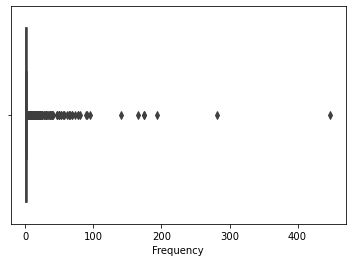

In [13]:
#Check Outlier on Frequency
sns.boxplot(lrfm['Frequency'])

<AxesSubplot:xlabel='Frequency'>

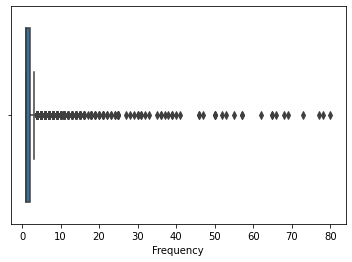

In [14]:
lrfm = lrfm[~(lrfm['Frequency'] > 80)]
sns.boxplot(x=lrfm['Frequency'])

Length's: Skew: 0.3268333849911444, : SkewtestResult(statistic=7.01338672312843, pvalue=2.3261731280569204e-12)
Recency's: Skew: 0.4613925432402897, : SkewtestResult(statistic=9.680675107294359, pvalue=3.6430232537990234e-22)
Frequency's: Skew: 6.966359715133643, : SkewtestResult(statistic=51.15877744199126, pvalue=0.0)
Monetary's: Skew: 8.056020772968786, : SkewtestResult(statistic=53.76424214373618, pvalue=0.0)


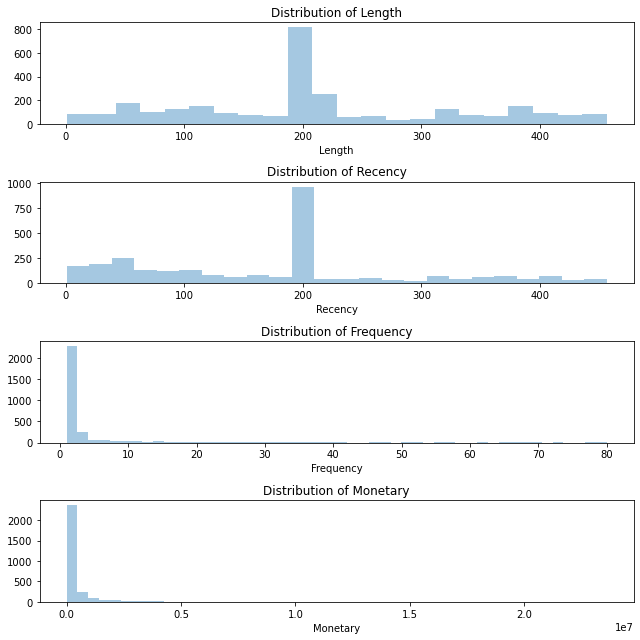

In [15]:
# Plot all 4 graphs to check skewness
plt.figure(figsize=(9, 9))

plt.subplot(4, 1, 1)
check_skew(lrfm,'Length')

plt.subplot(4, 1, 2)
check_skew(lrfm,'Recency')

plt.subplot(4, 1, 3)
check_skew(lrfm,'Frequency')

plt.subplot(4, 1, 4)
check_skew(lrfm,'Monetary')

plt.tight_layout()
plt.savefig('before_transform.png', format='png', dpi=1000)

In [ ]:
#Frequency dan monetary skewnya ndak masuk akal

## Transformation & Normalization

Length's: Skew: 0.3268333849911444, : SkewtestResult(statistic=7.01338672312843, pvalue=2.3261731280569204e-12)
Recency's: Skew: -0.3382384093415668, : SkewtestResult(statistic=-7.245928176935121, pvalue=4.294876753872309e-13)
Frequency's: Skew: 1.6745023962114858, : SkewtestResult(statistic=26.379951460551954, pvalue=2.3274475137623001e-153)
Monetary's: Skew: -0.4339049010832565, : SkewtestResult(statistic=-9.149859344501701, pvalue=5.700772467837856e-20)


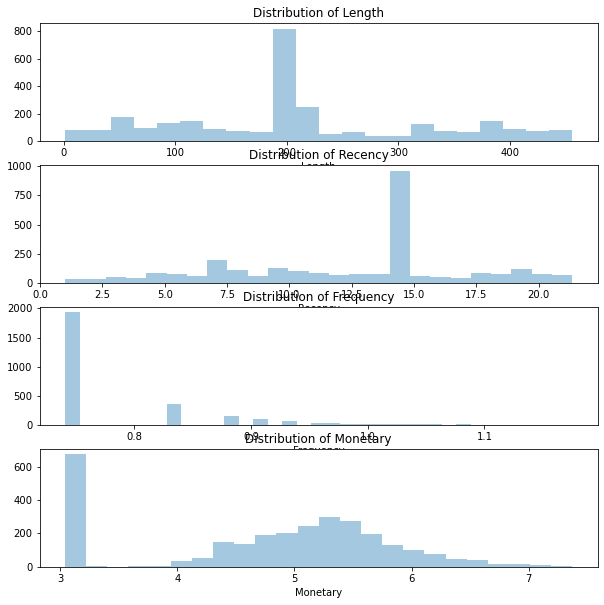

In [16]:
lrfm_trans = lrfm.copy()
#log10 Transformation
# lrfm_trans['Frequency'] = lrfm_trans['Frequency'].apply(lambda x: 1/x)
# lrfm_trans['Monetary'] = lrfm_trans['Monetary'].apply(lambda x: 1/x)

lrfm_trans['Recency'] = np.sqrt(lrfm_trans['Recency'])
lrfm_trans['Frequency'] = np.log10(lrfm_trans['Frequency']+1)
lrfm_trans['Monetary'] = np.log10(lrfm_trans['Monetary']+1)

lrfm_trans['Frequency'] = np.sqrt(lrfm_trans['Frequency'])

lrfm_trans['Frequency'] = np.sqrt(lrfm_trans['Frequency'])

plt.figure(figsize=(10, 10))
plt.subplot(4, 1, 1)
check_skew(lrfm_trans,'Length')
plt.subplot(4, 1, 2)
check_skew(lrfm_trans,'Recency')
plt.subplot(4, 1, 3)
check_skew(lrfm_trans,'Frequency')
plt.subplot(4, 1, 4)
check_skew(lrfm_trans,'Monetary')

In [17]:
#Min-Max Normalization
norm_lrfm = norm_minmax(lrfm_trans)
norm_lrfm.describe()

Length      Recency    Frequency     Monetary
count  2890.000000  2890.000000  2890.000000  2890.000000
mean      0.461874     0.557422     0.130762     0.394715
std       0.250606     0.232852     0.217763     0.250796
min       0.000000     0.000000     0.000000     0.000000
25%       0.274725     0.368473     0.000000     0.262570
50%       0.443956     0.645673     0.000000     0.458537
75%       0.610989     0.659433     0.207963     0.567943
max       1.000000     1.000000     1.000000     1.000000

# K-Means Clustering

## Elbow Method

In [18]:
#Elbow Method
distortions = [] 
inertias = [] 
mapping1 = {} 
mapping2 = {} 
K = range(2,10) 
  
for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k).fit(norm_lrfm) 
    kmeanModel.fit(norm_lrfm)     
      
    distortions.append(sum(np.min(cdist(lrfm, kmeanModel.cluster_centers_, 
                      'euclidean'),axis=1)) / norm_lrfm.shape[0]) 
    inertias.append(kmeanModel.inertia_) 
  
    mapping1[k] = sum(np.min(cdist(lrfm, kmeanModel.cluster_centers_, 
                 'euclidean'),axis=1)) / lrfm.shape[0] 
    mapping2[k] = kmeanModel.inertia_ 

Elbow at K = 4


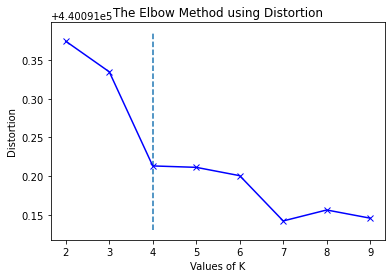

In [19]:
kn = KneeLocator(K, distortions, curve='convex', direction='decreasing')
print("Elbow at K =", kn.knee)

plt.plot(K, distortions, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method using Distortion') 
plt.vlines(kn.knee, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')
plt.savefig('Grafik/Elbow Method using Distortion.png', format='png', dpi=1000)
plt.show()

Elbow at K = 4


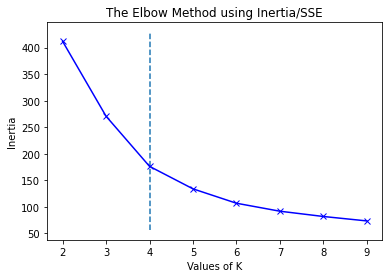

In [20]:
kn = KneeLocator(K, inertias, curve='convex', direction='decreasing')
print("Elbow at K =", kn.knee)

plt.plot(K, inertias, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Inertia') 
plt.title('The Elbow Method using Inertia/SSE') 
plt.vlines(kn.knee, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')
plt.savefig('Grafik/Elbow Method using Inertia.png', format='png', dpi=1000)
plt.show() 

## Silhouette Method

In [21]:
# Silhouette Method
euclidean = []
cosine = []
mapping_euclidean = {} 
K = range(1,10)

# Prepare models
for k in K: 
    kmeans = KMeans(n_clusters=6).fit(norm_lrfm)
    normalized_vectors = preprocessing.normalize(norm_lrfm)
    normalized_kmeans = KMeans(n_clusters=4).fit(normalized_vectors)
    min_samples = norm_lrfm.shape[1]+1

    euclidean.append(silhouette_score(norm_lrfm, kmeans.labels_, metric='euclidean'))
    cosine.append(silhouette_score(normalized_vectors, normalized_kmeans.labels_, metric='cosine'))

Highest Euclidean Value : 0.5220758901624262 at K=4


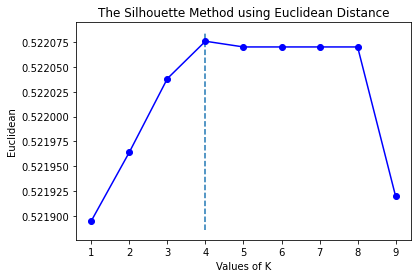

In [22]:
ymax = max(euclidean)
xpos = euclidean.index(ymax)
xmax = K[xpos]

print("Highest Euclidean Value = %s at K=%s" % (ymax, xmax,))
plt.plot(K, euclidean, 'bo-') 
plt.xlabel('Values of K') 
plt.ylabel('Euclidean') 
plt.title('The Silhouette Method using Euclidean Distance') 
plt.vlines(xmax, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')
plt.savefig('Grafik/Silhouette Method using Euclidean Distance.png', format='png', dpi=1000)
plt.show() 

Highest Cosine Value : 0.6648231724367072 at K=5


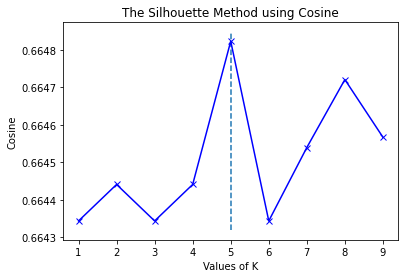

In [23]:
ymax = max(cosine)
xpos = cosine.index(ymax)
xmax = K[xpos]

print("Highest Cosine Value : %s at K=%s" % (ymax, xmax,))
plt.plot(K, cosine, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Cosine') 
plt.title('The Silhouette Method using Cosine') 
plt.vlines(xmax, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')
plt.savefig('Grafik/Silhouette Method using Cosine.png', format='png', dpi=1000)
plt.show() 

## Cluster!!

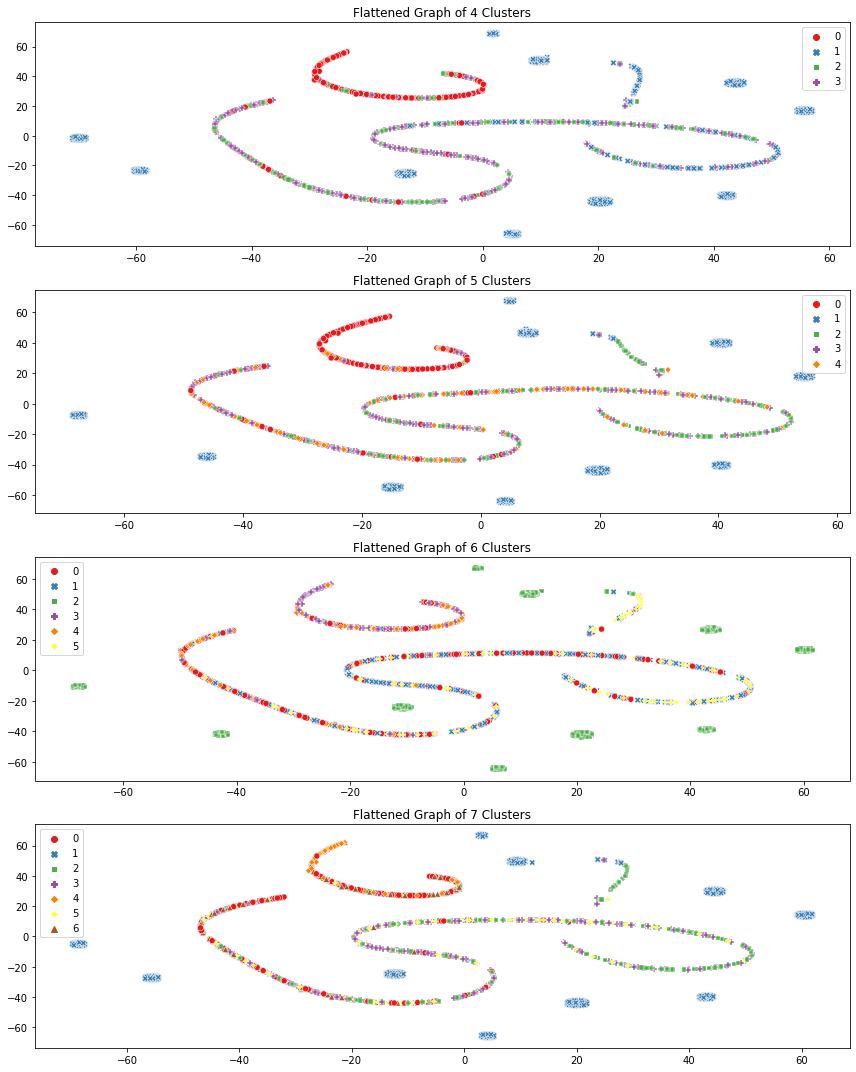

In [28]:
#Scatter Plot
plt.figure(figsize=(12, 15))

plt.subplot(4, 1, 1)
df_lrfm_k4 = kmeans(norm_lrfm, 4, lrfm)

plt.subplot(4, 1, 2)
df_lrfm_k5 = kmeans(norm_lrfm, 5, lrfm)

plt.subplot(4, 1, 3)
df_lrfm_k6 = kmeans(norm_lrfm, 6, lrfm)

plt.subplot(4, 1, 4)
df_lrfm_k7 = kmeans(norm_lrfm, 7, lrfm)

plt.tight_layout()
plt.savefig('Grafik/Cluster-flattened.png', format='png', dpi=300)

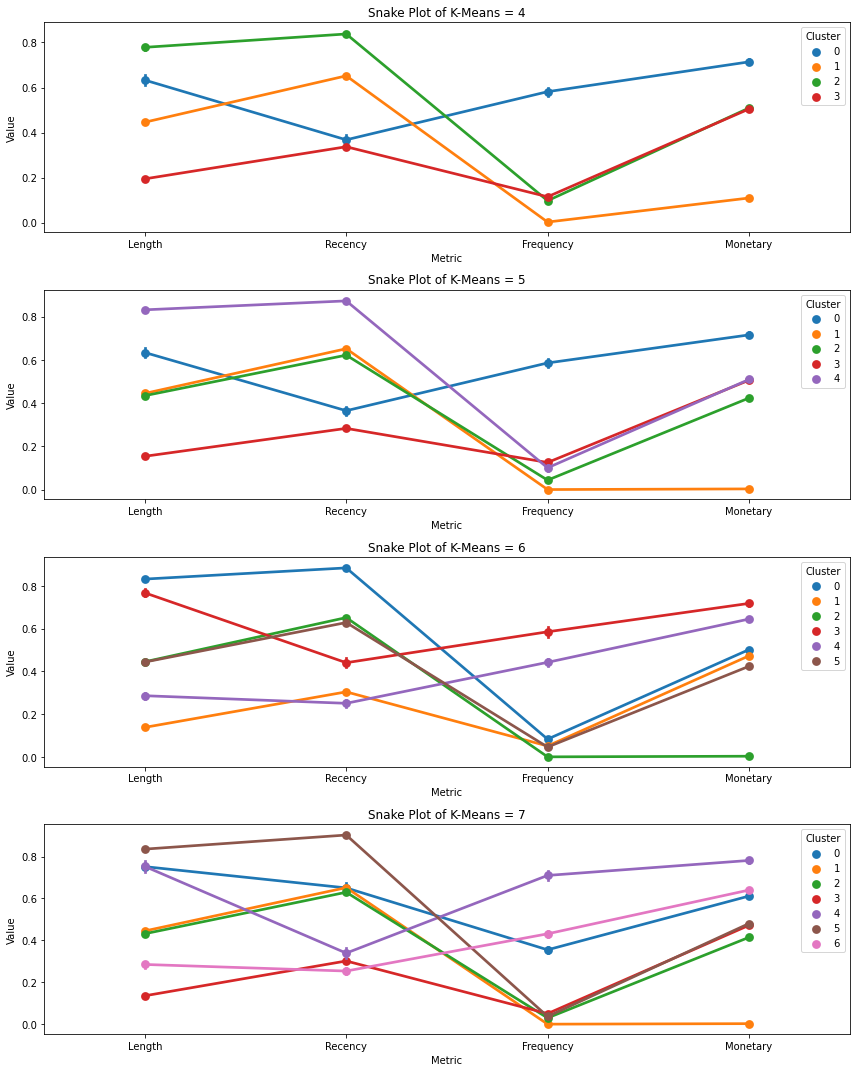

In [29]:
#Snake Plot
plt.figure(figsize=(12, 15))

plt.subplot(4, 1, 1)
plt.title('Snake Plot of K-Means = 4')
snake_plot(norm_lrfm, df_lrfm_k4, lrfm)

plt.subplot(4, 1, 2)
plt.title('Snake Plot of K-Means = 5')
snake_plot(norm_lrfm, df_lrfm_k5, lrfm)

plt.subplot(4, 1, 3)
plt.title('Snake Plot of K-Means = 6')
snake_plot(norm_lrfm, df_lrfm_k6, lrfm)

plt.subplot(4, 1, 4)
plt.title('Snake Plot of K-Means = 7')
snake_plot(norm_lrfm, df_lrfm_k7, lrfm)

plt.savefig('Grafik/Cluster-snakeplot.png', format='png', dpi=300)
plt.tight_layout()

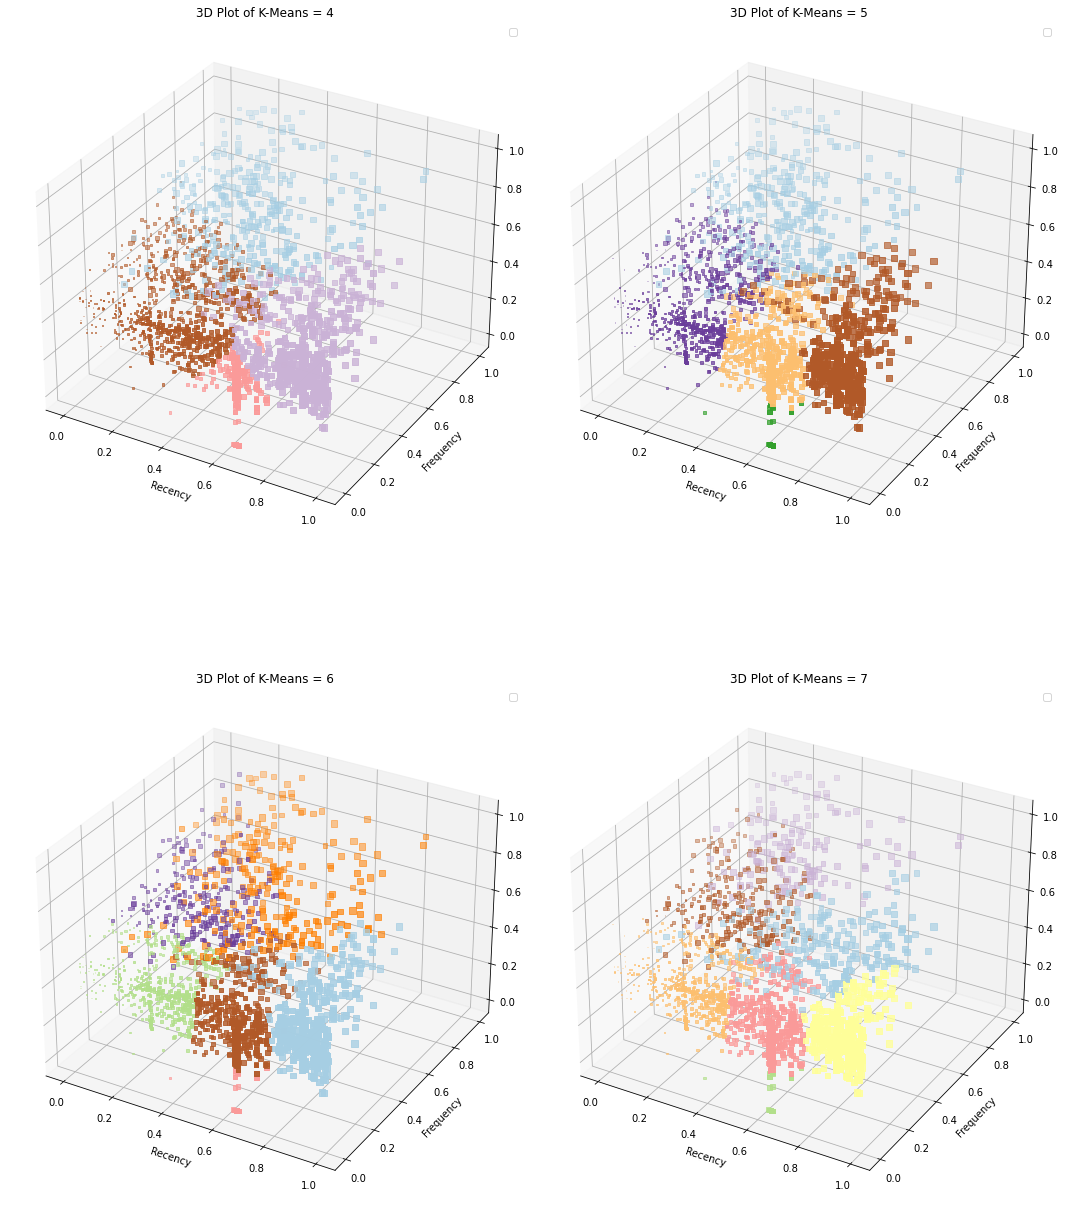

In [30]:
#3D Plot
fig = plt.figure(figsize=(15, 20))

ax = fig.add_subplot(2, 2, 1, projection='3d')
plt.title('3D Plot of K-Means = 4')
threeD_plot(norm_lrfm, df_lrfm_k4)

ax = fig.add_subplot(2, 2, 2, projection='3d')
plt.title('3D Plot of K-Means = 5')
threeD_plot(norm_lrfm, df_lrfm_k5)

ax = fig.add_subplot(2, 2, 3, projection='3d')
plt.title('3D Plot of K-Means = 6')
threeD_plot(norm_lrfm, df_lrfm_k6)

ax = fig.add_subplot(2, 2, 4, projection='3d')
plt.title('3D Plot of K-Means = 7')
threeD_plot(norm_lrfm, df_lrfm_k7)

plt.savefig('Grafik/Cluster-3DPlot.png', format='png', dpi=300)
plt.tight_layout()

In [31]:
#Pilih dataframe dengan jumlah cluster yang fix dipakai
df_cluster_fix = df_lrfm_k4.copy()

# Cluster Analysis

In [99]:
#Mengubah nilai Recency menggunakan 1-R karena merupakan kebalikan dari variabel lain
#R asli jika semakin kecil akan semakin bagus
df_lrfm_all = pd.merge(df_cluster_fix, norm_lrfm, on='telp', suffixes=('_real', '_norm'))
df_lrfm_all['Recency_norm'] = 1-df_lrfm_all['Recency_norm']

df_lrfm_all.to_csv("Ternakmart_Transaction_Clustered_LRFM.csv")
df_lrfm_all

Length_real  Recency_real  Frequency_real  Monetary_real  \
telp                                                                      
6280912371723          252           252               1       210900.0   
628111699469            66            66               1       165500.0   
628112068550           426           426               1       185000.0   
628112501890           412           344               9      1027000.0   
628113002154           361           103               2       296000.0   
...                    ...           ...             ...            ...   
628993972781           141            95               2        79800.0   
628996788009           376           376               1        27000.0   
628996930020           203           203               1        26100.0   
628999046770           251           251               1       156000.0   
628999348311           242           242               1        62000.0   

               Cluster  Length_norm  Recency_norm  Frequency_norm  \
telp                                                                
6280912371723        2     0.551648      0.269215        0.000000   
628111699469         3     0.142857      0.649996        0.000000   
628112068550         2     0.934066      0.035098        0.000000   
628112501890         2     0.903297      0.137904        0.596537   
628113002154         2     0.791209      0.550515        0.207963   
...                ...          ...           ...             ...   
628993972781         3     0.307692      0.570270        0.207963   
628996788009         2     0.824176      0.096464        0.000000   
628996930020         1     0.443956      0.349135        0.000000   
628999046770         2     0.549451      0.270764        0.000000   
628999348311         2     0.529670      0.284846        0.000000   

               Monetary_norm  
telp                          
6280912371723       0.526954  
628111699469        0.502646  
628112068550        0.513815  
628112501890        0.685687  
628113002154        0.560944  
...                      ...  
628993972781        0.429503  
628996788009        0.320840  
628996930020        0.317441  
628999046770        0.496719  
628999348311        0.404195  

[2890 rows x 9 columns]

In [62]:
def lrfm_values(df):
    lrfm_cluster = df.groupby(['Cluster']).agg(['mean', 'min', 'max']).round(3)
    return lrfm_cluster

In [63]:
#mean at every cluster
lrfm_values(df_lrfm_all)

Length_real           Recency_real          Frequency_real          \
               mean  min  max         mean min  max           mean min max   
Cluster                                                                      
0           288.931   51  456       85.964   1  362         13.069   2  80   
1           203.940   80  278      203.758  80  278          1.014   1   3   
2           355.139  199  456      331.250  84  456          1.627   1   9   
3            89.519    1  248       71.446   1  196          1.737   1  10   

        Monetary_real  ... Recency_norm Frequency_norm                \
                 mean  ...          max           mean    min    max   
Cluster                ...                                             
0         2374098.199  ...        1.000          0.581  0.208  1.000   
1           13691.168  ...        0.610          0.003  0.000  0.322   
2          274048.984  ...        0.599          0.097  0.000  0.597   
3          252524.178  ...        1.000          0.115  0.000  0.620   

        Monetary_norm                   CLV                   
                 mean    min    max    mean     min      max  
Cluster                                                       
0               0.714  0.446  1.000  95.104  66.170  137.656  
1               0.110  0.000  0.503  32.013  17.780   58.479  
2               0.509  0.240  0.807  70.663  50.216  105.367  
3               0.505  0.129  0.755  45.478  17.483   74.612  

[4 rows x 27 columns]

In [41]:
#mean from all dataframe
df_lrfm_all.mean(axis=0).round(3)

Length_real          211.153
Recency_real         174.875
Frequency_real         2.882
Monetary_real     440082.828
Cluster                1.716
Length_norm            0.462
Recency_norm           0.443
Frequency_norm         0.131
Monetary_norm          0.395
dtype: float64

## Menghitung CLV

In [42]:
#Nilai bobot didapatkan dari file excel
AHP = {
    'Length' : 0.52,
    'Recency' : 0.095,
    'Frequency' : 0.36,
    'Monetary' : 0.494}

count    2890.000000
mean        0.524283
std         0.243336
min         0.174828
25%         0.287894
50%         0.462623
75%         0.679138
max         1.376557
Name: CLV, dtype: float64

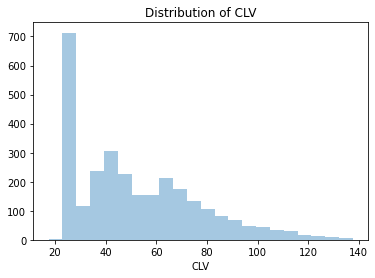

In [43]:
df_lrfm_all['CLV'] = (df_lrfm_all['Length_norm']*AHP['Length'] + df_lrfm_all['Recency_norm']*AHP['Recency'] + df_lrfm_all['Frequency_norm']*AHP['Frequency'] + df_lrfm_all['Monetary_norm']*AHP['Monetary'])
display(df_lrfm_all['CLV'].describe())

#Agar angka lebih cantik dan mudah dibaca, kita kalikan 1000
df_lrfm_all['CLV'] = df_lrfm_all['CLV']*100
plt.title('Distribution of CLV')
sns.distplot(df_lrfm_all['CLV'], kde=False)
plt.show()

## Rank CLV

In [44]:
def clv_values(df):
    clv_cluster = df.groupby(['Cluster']).agg({
        'Length_real': ['min', 'max', 'mean'],
        'Recency_real': ['min', 'max', 'mean'],
        'Frequency_real': ['min', 'max', 'mean'],
        'Monetary_real': ['min', 'max', 'mean'],
        'CLV' : 'mean'
    }).round(0)
    
    return clv_cluster

In [45]:
clv_values(df_lrfm_all).sort_values(by=[('CLV','mean')], ascending=False)

Length_real             Recency_real             Frequency_real      \
                min  max   mean          min  max   mean            min max   
Cluster                                                                       
0                51  456  289.0            1  362   86.0              2  80   
2               199  456  355.0           84  456  331.0              1   9   
3                 1  248   90.0            1  196   71.0              1  10   
1                80  278  204.0           80  278  204.0              1   3   

              Monetary_real                          CLV  
         mean           min         max       mean  mean  
Cluster                                                   
0        13.0       94000.0  23598900.0  2374098.0  95.0  
2         2.0       12000.0   3440000.0   274049.0  71.0  
3         2.0        4000.0   2060000.0   252524.0  45.0  
1         1.0        1100.0    165900.0    13691.0  32.0

In [48]:
#slice data berdasarkan cluster
df_lrfm_c0 = df_lrfm_all[lambda x: x['Cluster'] == 0]
df_lrfm_c1 = df_lrfm_all[lambda x: x['Cluster'] == 1]
df_lrfm_c2 = df_lrfm_all[lambda x: x['Cluster'] == 2]
df_lrfm_c3 = df_lrfm_all[lambda x: x['Cluster'] == 3]

<AxesSubplot:xlabel='Length_real'>

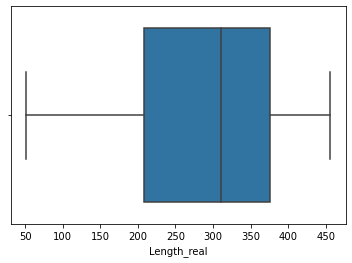

In [49]:
sns.boxplot(df_lrfm_c0['Length_real'])

# Market Basket Analysis

## Join Dataframe

In [50]:
df_basket_all = pd.merge(df_clean, df_cluster_fix, on='telp', how='left')
df_basket_all = df_basket_all[['delivery_date', 'no_order', 'telp', 'prod_id', 'produk', 'qty', 'Cluster']].copy()
df_basket_all['prod_id'] = df_basket_all['prod_id'].astype(int)

#drop NA from frequency outlier
df_basket_all.dropna(subset=['Cluster'], inplace=True)

print("Dataset dimension : " + str(df_basket_all.shape))
print('Jumlah Customer : ' + str(len(pd.unique(df_basket_all['telp']))))
print('Jumlah Transaksi : ' + str(len(pd.unique(df_basket_all['no_order']))))

Dataset dimension : (21147, 7)
Jumlah Customer : 2890
Jumlah Transaksi : 8330


## Testing all Cluster

In [51]:
#clean the product names
df_basket_all['produk'] = df_basket_all['produk'].str.strip()
df_basket_all['no_order'] = df_basket_all['no_order'].astype('str')

In [52]:
#Split/subsetting dataframe
df_basket_cluster0 = df_basket_all[lambda x: x['Cluster'] == 0]
df_basket_cluster1 = df_basket_all[lambda x: x['Cluster'] == 1]
df_basket_cluster2 = df_basket_all[lambda x: x['Cluster'] == 2]
df_basket_cluster3 = df_basket_all[lambda x: x['Cluster'] == 3]

### Create basket datafarme from transactions data with each row representing one basket

In [96]:
#one hot encode the basket
def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1

#create MBA for every cluster
def createMBA(basket_data) :
    totalTransactions = len(basket_data.index)
    totalCustomers = len(pd.unique(basket_data['telp']))
    minTransaction = totalTransactions*0.01
    min_support_calc = minTransaction/totalTransactions

    print('number of customer in cluster is', totalCustomers)
    print('number of baskets for analysis is', totalTransactions)
    print('minimum support value is ', round(min_support_calc*100, 4), '%')

    basket = basket_data.groupby(['no_order', 'produk'])['qty'].sum().unstack().reset_index().fillna(0).set_index('no_order')
    basket_sets = basket.applymap(encode_units)
    basket_sets.dropna(inplace=True)
    basket_sets = basket_sets.astype(int)
    # display(basket_sets.head(5))

    #create frequent items sets with clculated minimum support
    frequent_itemsets = fpgrowth(basket_sets, min_support=min_support_calc, use_colnames=True)
    # display(frequent_itemsets.describe())

    rules = association_rules(frequent_itemsets, metric="lift", min_threshold=0)
    rules.sort_values('support', ascending = False, inplace = True)
    display(rules.head(10))
    # rules.to_excel(r'Data/Ternakmart_Results_FPGrowth_Cluster5.xlsx', index=False)

    # rules[(rules['lift'] >= 0.2) & (rules['confidence'] >= 0.1)].sort_values(by=['confidence', 'lift'], ascending=False).to_excel(r'Ternakmart_Results_FPGrowth_Cluster0.xlsx', index=False)

createMBA(df_basket_cluster1)

number of customer in cluster is 1002
number of baskets for analysis is 1372
minimum support value is  1.0 %


antecedents  \
8                          (GULA PASIR 1KG)   
9                (DAGING AYAM KARKAS 500GR)   
6                (DAGING AYAM KARKAS 500GR)   
7  (TELUR AYAM NEGERI 1PACK (ISI 15 BUTIR))   
2                (DAGING AYAM KARKAS 500GR)   
3      (INDOMIE MIE GORENG 75GR (OBSOLETE))   
4                     (Ayam Utuh SP 1.0 kg)   
5                (DAGING AYAM KARKAS 500GR)   
0                  (DAGING AYAM SAYAP 500G)   
1                (DAGING AYAM KARKAS 500GR)   

                                consequents  antecedent support  \
8                (DAGING AYAM KARKAS 500GR)            0.044291   
9                          (GULA PASIR 1KG)            0.895669   
6  (TELUR AYAM NEGERI 1PACK (ISI 15 BUTIR))            0.895669   
7                (DAGING AYAM KARKAS 500GR)            0.033465   
2      (INDOMIE MIE GORENG 75GR (OBSOLETE))            0.895669   
3                (DAGING AYAM KARKAS 500GR)            0.023622   
4                (DAGING AYAM KARKAS 500GR)            0.021654   
5                     (Ayam Utuh SP 1.0 kg)            0.895669   
0                (DAGING AYAM KARKAS 500GR)            0.020669   
1                  (DAGING AYAM SAYAP 500G)            0.895669   

   consequent support   support  confidence      lift  leverage  conviction  
8            0.895669  0.038386    0.866667  0.967619 -0.001285    0.782480  
9            0.044291  0.038386    0.042857  0.967619 -0.001285    0.998502  
6            0.033465  0.027559    0.030769  0.919457 -0.002414    0.997219  
7            0.895669  0.027559    0.823529  0.919457 -0.002414    0.591207  
2            0.023622  0.019685    0.021978  0.930403 -0.001473    0.998319  
3            0.895669  0.019685    0.833333  0.930403 -0.001473    0.625984  
4            0.895669  0.019685    0.909091  1.014985  0.000291    1.147638  
5            0.021654  0.019685    0.021978  1.014985  0.000291    1.000332  
0            0.895669  0.017717    0.857143  0.956986 -0.000796    0.730315  
1            0.020669  0.017717    0.019780  0.956986 -0.000796    0.999093

In [97]:
for i in range(4) :
    #slice data
    print("Market Basket Analysis for Cluster", i)
    basket_data = df_basket_all[lambda x: x['Cluster'] == i]
    createMBA(basket_data)
    print("\n \n")

Market Basket Analysis for Cluster 0
number of customer in cluster is 362
number of baskets for analysis is 13211
minimum support value is  1.0 %


antecedents                      consequents  \
0   (JABMILK SUSU RASA STROBERI 1L)    (JABMILK SUSU RASA COKLAT 1L)   
1     (JABMILK SUSU RASA COKLAT 1L)  (JABMILK SUSU RASA STROBERI 1L)   
4     (JABMILK SUSU RASA COKLAT 1L)  (JABMILK SUSU RASA ORIGINAL 1L)   
5   (JABMILK SUSU RASA ORIGINAL 1L)    (JABMILK SUSU RASA COKLAT 1L)   
40     (DAGING AYAM FILLET DADA KG)     (DAGING AYAM FILLET PAHA KG)   
41     (DAGING AYAM FILLET PAHA KG)     (DAGING AYAM FILLET DADA KG)   
17    (JABMILK SUSU RASA COKLAT 1L)     (JABMILK SUSU RASA MELON 1L)   
16     (JABMILK SUSU RASA MELON 1L)    (JABMILK SUSU RASA COKLAT 1L)   
2   (JABMILK SUSU RASA STROBERI 1L)  (JABMILK SUSU RASA ORIGINAL 1L)   
3   (JABMILK SUSU RASA ORIGINAL 1L)  (JABMILK SUSU RASA STROBERI 1L)   

    antecedent support  consequent support   support  confidence      lift  \
0             0.052052            0.064113  0.027931    0.536585  8.369315   
1             0.064113            0.052052  0.027931    0.435644  8.369315   
4             0.064113            0.050148  0.026661    0.415842  8.292267   
5             0.050148            0.064113  0.026661    0.531646  8.292267   
40            0.109395            0.091832  0.024122    0.220503  2.401144   
41            0.091832            0.109395  0.024122    0.262673  2.401144   
17            0.064113            0.042531  0.022218    0.346535  8.147874   
16            0.042531            0.064113  0.022218    0.522388  8.147874   
2             0.052052            0.050148  0.021160    0.406504  8.106068   
3             0.050148            0.052052  0.021160    0.421941  8.106068   

    leverage  conviction  
0   0.024593    2.019545  
1   0.024593    1.679696  
4   0.023446    1.626018  
5   0.023446    1.998244  
40  0.014076    1.165069  
41  0.014076    1.207883  
17  0.019491    1.465218  
16  0.019491    1.959513  
2   0.018549    1.600435  
3   0.018549    1.639880


 

Market Basket Analysis for Cluster 1
number of customer in cluster is 1002
number of baskets for analysis is 1372
minimum support value is  1.0 %


antecedents  \
8                          (GULA PASIR 1KG)   
9                (DAGING AYAM KARKAS 500GR)   
6                (DAGING AYAM KARKAS 500GR)   
7  (TELUR AYAM NEGERI 1PACK (ISI 15 BUTIR))   
2                (DAGING AYAM KARKAS 500GR)   
3      (INDOMIE MIE GORENG 75GR (OBSOLETE))   
4                     (Ayam Utuh SP 1.0 kg)   
5                (DAGING AYAM KARKAS 500GR)   
0                  (DAGING AYAM SAYAP 500G)   
1                (DAGING AYAM KARKAS 500GR)   

                                consequents  antecedent support  \
8                (DAGING AYAM KARKAS 500GR)            0.044291   
9                          (GULA PASIR 1KG)            0.895669   
6  (TELUR AYAM NEGERI 1PACK (ISI 15 BUTIR))            0.895669   
7                (DAGING AYAM KARKAS 500GR)            0.033465   
2      (INDOMIE MIE GORENG 75GR (OBSOLETE))            0.895669   
3                (DAGING AYAM KARKAS 500GR)            0.023622   
4                (DAGING AYAM KARKAS 500GR)            0.021654   
5                     (Ayam Utuh SP 1.0 kg)            0.895669   
0                (DAGING AYAM KARKAS 500GR)            0.020669   
1                  (DAGING AYAM SAYAP 500G)            0.895669   

   consequent support   support  confidence      lift  leverage  conviction  
8            0.895669  0.038386    0.866667  0.967619 -0.001285    0.782480  
9            0.044291  0.038386    0.042857  0.967619 -0.001285    0.998502  
6            0.033465  0.027559    0.030769  0.919457 -0.002414    0.997219  
7            0.895669  0.027559    0.823529  0.919457 -0.002414    0.591207  
2            0.023622  0.019685    0.021978  0.930403 -0.001473    0.998319  
3            0.895669  0.019685    0.833333  0.930403 -0.001473    0.625984  
4            0.895669  0.019685    0.909091  1.014985  0.000291    1.147638  
5            0.021654  0.019685    0.021978  1.014985  0.000291    1.000332  
0            0.895669  0.017717    0.857143  0.956986 -0.000796    0.730315  
1            0.020669  0.017717    0.019780  0.956986 -0.000796    0.999093


 

Market Basket Analysis for Cluster 2
number of customer in cluster is 620
number of baskets for analysis is 2306
minimum support value is  1.0 %


antecedents                      consequents  \
8   (JABMILK SUSU RASA STROBERI 1L)    (JABMILK SUSU RASA COKLAT 1L)   
9     (JABMILK SUSU RASA COKLAT 1L)  (JABMILK SUSU RASA STROBERI 1L)   
21  (JABMILK SUSU RASA STROBERI 1L)     (JABMILK SUSU RASA MELON 1L)   
20     (JABMILK SUSU RASA MELON 1L)  (JABMILK SUSU RASA STROBERI 1L)   
32     (DAGING AYAM FILLET DADA KG)           (TELUR AYAM NEGERI KG)   
33           (TELUR AYAM NEGERI KG)     (DAGING AYAM FILLET DADA KG)   
12  (JABMILK SUSU RASA STROBERI 1L)  (JABMILK SUSU RASA ORIGINAL 1L)   
13  (JABMILK SUSU RASA ORIGINAL 1L)  (JABMILK SUSU RASA STROBERI 1L)   
2      (DAGING AYAM FILLET DADA KG)     (DAGING AYAM FILLET PAHA KG)   
3      (DAGING AYAM FILLET PAHA KG)     (DAGING AYAM FILLET DADA KG)   

    antecedent support  consequent support   support  confidence      lift  \
8             0.071358            0.067393  0.033697    0.472222  7.006944   
9             0.067393            0.071358  0.033697    0.500000  7.006944   
21            0.071358            0.047572  0.021804    0.305556  6.423032   
20            0.047572            0.071358  0.021804    0.458333  6.423032   
32            0.114965            0.136769  0.021804    0.189655  1.386682   
33            0.136769            0.114965  0.021804    0.159420  1.386682   
12            0.071358            0.061447  0.020813    0.291667  4.746640   
13            0.061447            0.071358  0.020813    0.338710  4.746640   
2             0.114965            0.077304  0.020813    0.181034  2.341844   
3             0.077304            0.114965  0.020813    0.269231  2.341844   

    leverage  conviction  
8   0.028888    1.767044  
9   0.028888    1.857284  
21  0.018409    1.371497  
20  0.018409    1.714416  
32  0.006080    1.065264  
33  0.006080    1.052886  
12  0.016428    1.325016  
13  0.016428    1.404288  
2   0.011925    1.126660  
3   0.011925    1.211100


 

Market Basket Analysis for Cluster 3
number of customer in cluster is 906
number of baskets for analysis is 4258
minimum support value is  1.0 %


antecedents                   consequents  \
0  (DAGING AYAM FILLET DADA KG)  (DAGING AYAM FILLET PAHA KG)   
1  (DAGING AYAM FILLET PAHA KG)  (DAGING AYAM FILLET DADA KG)   

   antecedent support  consequent support   support  confidence      lift  \
0            0.069010            0.074121  0.015335    0.222222  2.998084   
1            0.074121            0.069010  0.015335    0.206897  2.998084   

   leverage  conviction  
0   0.01022    1.190415  
1   0.01022    1.173857

# ==========BATAS SUCI KODINGAN==========

In [82]:
#create basket dataframe
basket = df_basket_cluster1.groupby(['no_order', 'produk'])['qty'].sum().unstack().reset_index().fillna(0).set_index('no_order')
basket_sets = basket.applymap(encode_units)
basket_sets.dropna(inplace=True)
basket_sets = basket_sets.astype(int)
basket_sets.head(5)
# basket_sets.to_csv("Data/basket_sets_Ternakmart_Transaction apr19 to apr21 (raw).csv")

#create minTransactions variable to represent the minimum number of baskets for support parameter
totalTransactions = len(basket_sets.index)
# totalCustomers = len(pd.unique(basket_sets['telp'])
minTransaction = totalTransactions*0.01
min_support_calc = minTransaction/totalTransactions

print('number of baskets for analysis is', totalTransactions)
print('minimum support value is ', round(min_support_calc*100, 4), '%')

#create frequent items sets with clculated minimum support
frequent_itemsets = fpgrowth(basket_sets, min_support=min_support_calc, use_colnames=True)
frequent_itemsets.describe()

rules = association_rules(frequent_itemsets, metric="lift", min_threshold=0)
rules.sort_values('support', ascending = False, inplace = True)
rules.head(10)
# rules.to_excel(r'Data/Ternakmart_Results_FPGrowth_Cluster5.xlsx', index=False)

# rules[(rules['lift'] >= 0.2) & (rules['confidence'] >= 0.1)].sort_values(by=['confidence', 'lift'], ascending=False).to_excel(r'Ternakmart_Results_FPGrowth_Cluster0.xlsx', index=False)

number of baskets for analysis is 1016
minimum support value is  1.0 %


antecedents  \
8                          (GULA PASIR 1KG)   
9                (DAGING AYAM KARKAS 500GR)   
6                (DAGING AYAM KARKAS 500GR)   
7  (TELUR AYAM NEGERI 1PACK (ISI 15 BUTIR))   
2                (DAGING AYAM KARKAS 500GR)   
3      (INDOMIE MIE GORENG 75GR (OBSOLETE))   
4                     (Ayam Utuh SP 1.0 kg)   
5                (DAGING AYAM KARKAS 500GR)   
0                  (DAGING AYAM SAYAP 500G)   
1                (DAGING AYAM KARKAS 500GR)   

                                consequents  antecedent support  \
8                (DAGING AYAM KARKAS 500GR)            0.044291   
9                          (GULA PASIR 1KG)            0.895669   
6  (TELUR AYAM NEGERI 1PACK (ISI 15 BUTIR))            0.895669   
7                (DAGING AYAM KARKAS 500GR)            0.033465   
2      (INDOMIE MIE GORENG 75GR (OBSOLETE))            0.895669   
3                (DAGING AYAM KARKAS 500GR)            0.023622   
4                (DAGING AYAM KARKAS 500GR)            0.021654   
5                     (Ayam Utuh SP 1.0 kg)            0.895669   
0                (DAGING AYAM KARKAS 500GR)            0.020669   
1                  (DAGING AYAM SAYAP 500G)            0.895669   

   consequent support   support  confidence      lift  leverage  conviction  
8            0.895669  0.038386    0.866667  0.967619 -0.001285    0.782480  
9            0.044291  0.038386    0.042857  0.967619 -0.001285    0.998502  
6            0.033465  0.027559    0.030769  0.919457 -0.002414    0.997219  
7            0.895669  0.027559    0.823529  0.919457 -0.002414    0.591207  
2            0.023622  0.019685    0.021978  0.930403 -0.001473    0.998319  
3            0.895669  0.019685    0.833333  0.930403 -0.001473    0.625984  
4            0.895669  0.019685    0.909091  1.014985  0.000291    1.147638  
5            0.021654  0.019685    0.021978  1.014985  0.000291    1.000332  
0            0.895669  0.017717    0.857143  0.956986 -0.000796    0.730315  
1            0.020669  0.017717    0.019780  0.956986 -0.000796    0.999093

In [ ]:
#create basket dataframe
# basket = df_basket_all.groupby(['no_order', 'produk'])['qty'].sum().unstack().reset_index().fillna(0).set_index('no_order')
# basket_sets = basket.applymap(encode_units)
# basket_sets.dropna(inplace=True)
# basket_sets = basket_sets.astype(int)
# basket_sets.head(5)
# basket_sets.to_csv("Data/basket_sets_Ternakmart_Transaction apr19 to apr21 (raw).csv")

#create minTransactions variable to represent the minimum number of baskets for support parameter
# minTransaction = 150
# totalTransactions = len(basket_sets.index)
# min_support_calc = minTransaction/totalTransactions

# print('number of baskets for analysis is', totalTransactions)
# print('minimum support value is ', round(min_support_calc*100, 4), '%')

#create frequent items sets with clculated minimum support
# frequent_itemsets = fpgrowth(basket_sets, min_support=min_support_calc, use_colnames=True)
# frequent_itemsets.describe()

# rules = association_rules(frequent_itemsets, metric="lift", min_threshold=0.5)
# rules.sort_values('confidence', ascending = False, inplace = True)
# rules.head(10)

# rules[(rules['lift'] >= 0.2) & (rules['confidence'] >= 0.1)].sort_values(by=['confidence', 'lift'], ascending=False).to_excel(r'Data/Ternakmart_Results_FPGrowth.xlsx', index=False)

In [ ]:
# basket_sets = basket.applymap(encode_units)
# basket_sets.dropna(inplace=True)
# basket_sets = basket_sets.astype(int)
# basket_sets.head(5)

In [ ]:
#create basket dataframe
# basket = df_basket_all.groupby(['no_order', 'produk'])['qty'].sum().unstack().reset_index().fillna(0).set_index('no_order')
# basket.head()

In [ ]:
# basket_sets.to_csv("Data/basket_sets_Ternakmart_Transaction apr19 to apr21 (raw).csv")

### Run FP-growth algorithm on frequent item sets (items that frequently appear in the same basket)

In [ ]:
#create minTransactions variable to represent the minimum number of baskets for support parameter
# minTransaction = 150
# totalTransactions = len(basket_sets.index)
# min_support_calc = minTransaction/totalTransactions

# print('number of baskets for analysis is', totalTransactions)
# print('minimum support value is ', round(min_support_calc*100, 4), '%')

In [ ]:
#create frequent items sets with clculated minimum support
# frequent_itemsets = fpgrowth(basket_sets, min_support=min_support_calc, use_colnames=True)
# frequent_itemsets.describe()

In [ ]:
# rules = association_rules(frequent_itemsets, metric="lift", min_threshold=0.5)
# rules.sort_values('confidence', ascending = False, inplace = True)
# rules.head(10)

In [ ]:
# rules[(rules['lift'] >= 0.4) & (rules['confidence'] >= 0.1)].sort_values(by=['confidence', 'lift'], ascending=False).to_excel(r'Data/Ternakmart_Results_FPGrowth.xlsx', index=False)